### Scale Invariant Blob Detector

A scale invariant detector.  Laplacian blob detector is one of the basic methods which generates features that are invariant to scaling.

![](img\auto_scale.png)

Here are some of the basics of the blob filter. The whole process boils down to two steps

- Convolve image with scale-normalized Laplacian at several scales (different scales means different sigma)
- Find maxima of squared Laplacian response in scale-space

The code has four main steps:

1. Generation of LOG filters
2. Convolving the images with Gaussian filters
3. Finding the maximum peak
4. Drawing the blobs.

Source: https://github.com/eshaan90/sift-feature-detector

In [2]:
import cv2
import sys
import numpy as np
import time
import matplotlib.pyplot as plt

In [3]:
def output_image_size(img,f,p):
    size=img.shape
    v_dim=size[0]+2*p-f+1
    h_dim=size[1]+2*p-f+1
    output_img=np.zeros((v_dim,h_dim), dtype=float)
    return output_img

def convolve(image,kernel):
    
    f=kernel.shape[0]
    iH, iW = np.shape(image)
    p=int((f-1)/2)
    padded_img=np.pad(image,p,'constant')
    output_img=output_image_size(image,f,p)
    
    for y in range(p, iH + p):
            for x in range(p, iW + p):
                roi = padded_img[y - p:y + p + 1, x - p:x + p + 1]
                k = (roi * kernel).sum()
                output_img[y - p, x - p] = k
                
    return output_img

### LoG Filters

![](img\log.png)

In [4]:
def laplacian_of_gaussian_filter(sigma):
    kernel_size = np.round(6*sigma)
    if kernel_size % 2 == 0:
        kernel_size+=1
    half_size=np.floor(kernel_size/2)
    x, y = np.meshgrid(np.arange(-half_size, half_size+1), np.arange(-half_size, half_size+1))
    
    exp_term=np.exp(-(x**2+y**2) / (2*sigma**2))
    exp_term[exp_term < sys.float_info.epsilon * exp_term.max()] = 0
    if exp_term.sum() != 0:
        exp_term = exp_term/exp_term.sum() 
    else: 
        exp_term
    kernel = -((x**2 + y**2 - (2*sigma**2)) / sigma**2) * exp_term 
    kernel=kernel-kernel.mean()
    return kernel

In [5]:
def max_supression(scale_space, sigma, threshold_factor, level):
    max_scale_space = np.copy(scale_space)
    mask = [0]*(level)
    index = [(1, 0), (-1, 0), (0, 1), (0, -1), 
             (1, 1), (1, -1), (-1, 1), (-1, -1)]
    for i in range(0,level):
        mask[i]=int(np.ceil(np.sqrt(2)*sigma[i]))
    size = np.shape(scale_space[:,:,0])
    
    def check(l):
        return all(scale_space[i + dx, j + dy, l] < scale_space[i, j, k] 
                   for dx, dy in index 
                   if  0<= i + dx < size[0] and 0<= j + dy <size[1])
    
    blob_location =[]
    for k in range(0,level):
        max_scale_space[:mask[k],:mask[k],k] = 0
        max_scale_space[-mask[k]:,-mask[k]:,k] = 0
        for i in range(mask[k]+1,size[0]-mask[k]-1):
            for j in range(mask[k]+1,size[1]-mask[k]-1):
                if scale_space[i, j, k] < threshold_factor:
                    continue
                c_max = check(k)
                l_max = u_max = True
                if k - 1 >= 0:
                    l_max = check(k - 1) and \
                    scale_space[i, j, k - 1] < scale_space[i, j, k]
                if k + 1 < level:
                    u_max = check(k + 1) and \
                    scale_space[i, j, k + 1] < scale_space[i, j, k]
                if c_max and l_max and u_max:
                    max_scale_space[i, j, k] = 1
                    blob_location.append((i,j,k))   
    return blob_location

In [16]:
def create_scale_space(gray_image,sigma_scale_factor,initial_sigma,level):
    h,w=np.shape(gray_image)
    scale_space = np.zeros((h,w,level),np.float32)
    sigma = [0]*(level+1)
    sigma[0] = initial_sigma
    for i in range(0,level):
        print('Convolving with sigma={}'.format(sigma[i]))
        kernel=laplacian_of_gaussian_filter(sigma[i])
        convolved_image=convolve(gray_image,kernel)
        #cv2.imshow("LoG Convolved Image with sigma={}".format(sigma[i]),convolved_image)
        scale_space[:,:,i] = np.square(convolved_image)
        sigma[i+1]=sigma[i]*sigma_scale_factor
    return scale_space,sigma

In [ ]:
def main():
    #-----------Modify these parameters-----------
    level=14
    threshold_factor=0.02
    initial_sigma=1.35
    sigma_scale_factor=1.24
    #---------------------------------------------
    
    filelocation="TestImages4Project/tiger.jpg"
    image = read_images(filelocation)
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray_image = cv2.normalize(gray_image.astype('float'), None, 0.0, 1.0, cv2.NORM_MINMAX)

    start_time = time.time()
    scale_space,sigma = create_scale_space(gray_image,sigma_scale_factor,
                                           initial_sigma,level) 

    blob_location = max_supression(scale_space,
                                   sigma,
                                   threshold_factor,
                                   level) 
    no_of_blobs=len(blob_location)
    for center in blob_location:
        radius = int(np.ceil(np.sqrt(2)*sigma[center[2]])) 
        cv2.circle(image,(center[1],center[0]),radius, (0,0,255))
    
    print("Number of Blobs=", no_of_blobs)
    print("Total Time Taken (in seconds): {}".format(time.time() - start_time))

    cv2.imshow("Blob Threshold={},Initial Sigma={}, {} circles".format(threshold_factor,initial_sigma, no_of_blobs),image)
    cv2.waitKey(0)
    cv2.destroyAllWindows() 

In [17]:
def display(img,blob_location):
    fig, ax = plt.subplots(1,1, figsize=[10,10])
    ax.imshow(img, interpolation='nearest',cmap="gray")
    
    for center in blob_location:
        radius = int(np.ceil(np.sqrt(2)*sigma[center[2]])) 
        c=plt.Circle((center[1],center[0]),radius, color='red', linewidth=1.,fill=False)
        ax.add_patch(c)
    ax.plot()  
    plt.show()

In [38]:
def imgDetect(filelocation):
    level=14
    threshold_factor=0.02
    initial_sigma=1.35
    sigma_scale_factor=1.24


    #filelocation="img/sgraf2.jpg"
    image = cv2.imread(filelocation)
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray_image = cv2.normalize(gray_image.astype('float'), None, 0.0, 1.0, cv2.NORM_MINMAX)

    start_time = time.time()
    scale_space,sigma = create_scale _space(gray_image,sigma_scale_factor,initial_sigma,level) 

    blob_location = max_supression(scale_space, sigma, threshold_factor,level) 
    no_of_blobs=len(blob_location)

    #display(image,blob_location)
    for center in blob_location:
        radius = int(np.ceil(np.sqrt(2)*sigma[center[2]])) 
        cv2.circle(image,(center[1],center[0]),radius, (0,0,255))
        
    print("Number of Blobs=", no_of_blobs)
    print("Total Time Taken (in seconds): {}".format(time.time() - start_time))
    
    cv2.imshow("Blob Threshold={},Initial Sigma={}, {} circles".format(threshold_factor,initial_sigma, no_of_blobs),image)
    cv2.waitKey(0)
    cv2.destroyAllWindows() 
    return image, blob_location

### Sample Images

We display some sample images, both are different sizes.

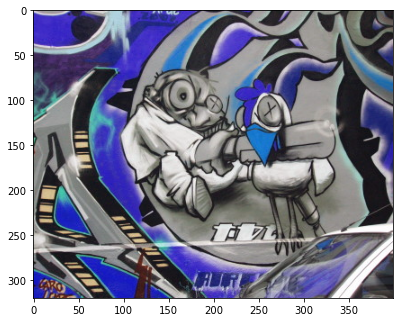

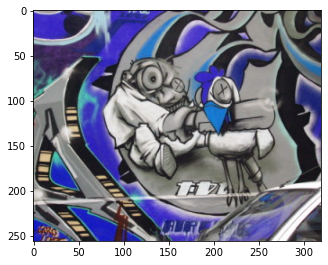

In [43]:
img1 = cv2.imread("img/sgraf1.jpg")
img2 = cv2.imread("img/sgraf2.jpg")
dpi=80
h1, w1, channels = img1.shape
figs1 = w1 / float(dpi), h1 / float(dpi)
h2, w2, channels = img2.shape
figs2 = w2 / float(dpi), h2 / float(dpi)

# Create a figure of the right size with one axes that takes up the full figure
fig1 = plt.figure(figsize=figs1)
fig2 = plt.figure(figsize=figs2)
ax1=fig1.add_axes([0, 0, 1, 1])
ax2=fig2.add_axes([0, 0, 1, 1])

ax1.imshow(img1, cmap='gray')
ax2.imshow(img2, cmap='gray')

### Detecting Features

We try to detect the features in both images. Ideally the features should be in the matching location, even though the images are of different scale, etc. 

In [10]:
img1,blob1=imgDetect("img/sgraf1.jpg")
img2,blob2=imgDetect("img/sgraf2.jpg")
#display(img1,blob1)
#display(img2,blob2)

Convolving with sigma=1.35
Convolving with sigma=1.6740000000000002
Convolving with sigma=2.0757600000000003
Convolving with sigma=2.5739424000000004
Convolving with sigma=3.1916885760000007
Convolving with sigma=3.957693834240001
Convolving with sigma=4.907540354457601
Convolving with sigma=6.085350039527425
Convolving with sigma=7.545834049014007
Convolving with sigma=9.356834220777369
Convolving with sigma=11.602474433763938
Convolving with sigma=14.387068297867282
Convolving with sigma=17.83996468935543
Convolving with sigma=22.121556214800734
Number of Blobs= 1547
Total Time Taken (in seconds): 17.519815921783447
Convolving with sigma=1.35
Convolving with sigma=1.6740000000000002
Convolving with sigma=2.0757600000000003
Convolving with sigma=2.5739424000000004
Convolving with sigma=3.1916885760000007
Convolving with sigma=3.957693834240001
Convolving with sigma=4.907540354457601
Convolving with sigma=6.085350039527425
Convolving with sigma=7.545834049014007
Convolving with sigma=9

### Display results side by side

In [49]:
def display2(img,blob_location):
    fig, axes = plt.subplots(1,2, figsize=[14,14])
    for i, ax in enumerate(axes.ravel()):
        ax.imshow(img[i], interpolation='nearest',cmap="gray")
        for center in blob_location[i]:
            radius = int(np.ceil(np.sqrt(2) *sigma[center])) 
            #radius = np.sqrt(2) * sigmas[center[2]] 
            c=plt.Circle((center[1],center[0]),radius, color='red', linewidth=1.,fill=False)
            ax.add_patch(c)
        ax.plot(1,2,i+1)  
    plt.show()

NameError: name 'sigma' is not defined

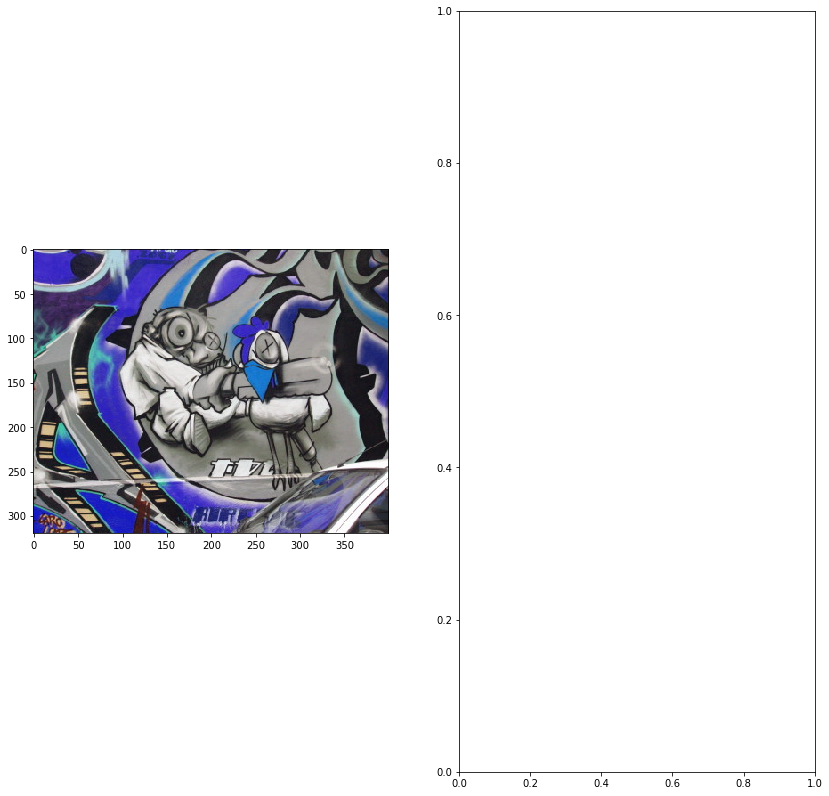

In [50]:
img=[img1,img2]
blob=[blob1,blob2]
display2(img,blob)

### Question

1. Try comparing the blob feature with two images of different sizes (sgraf1.jpg and sgraf2.jpg), rotated versions (sgraf3.jpg) and stretched or distorted versions. How good are the feature detectors? Are they scale and rotation invariant?
2. Test again with your own images that you have drawn or created (i.e from your mobile camera). 
3. What is the use of such feature detector? List some applications.

### Answer
3.  
face detection  
Product size detection, product direction, position, angle detection, etc. on automated production lines